<a href="https://colab.research.google.com/github/adipai/data-decent/blob/main/src/experiments/Moodle_Vuln_sampling_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmlb

In [4]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.8/169.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sdmetrics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 17.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_c

In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/imbalance_defects_prediction/
   creating: data/project_health/
  inflating: data/README.md          
   creating: data/JavaScript_Vulnerability/
   creating: data/Bug_Reports/
   creating: data/Vulnerable_Files/
   creating: data/defects_prediction/
   creating: data/imbalance_defects_prediction/7_CK_NET_PROC/
   creating: data/imbalance_defects_prediction/2_NET/
   creating: data/imbalance_defects_prediction/4_CK_NET/
   creating: data/imbalance_defects_prediction/3_PROC/
   creating: data/imbalance_defects_prediction/6_NET_PROC/
   creating: data/imbalance_defects_prediction/1_CK/
   creating: data/imbalance_defects_prediction/5_CK_PROC/
   creating: data/project_health/monthly_closed_PRs_2mo/
   creating: data/project_health/monthly_commits_2mo/
   creating: data/project_health/monthly_open_PRs_2mo/
   creating: data/project_health/monthly_closed_issues_2mo/
   creating: data/project_health/monthly_commits_12mo/
   creating: d

In [6]:
# All imports here
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pmlb import fetch_data
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

from scipy.io import arff
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
# from DataSynthesizer.DataDescriber import DataDescriber
# from DataSynthesizer.DataGenerator import DataGenerator
# from DataSynthesizer.lib.utils import display_bayesian_network
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

## Data preprocessing

In [7]:
def preprocess_data_train(X_train):
    # Count missing values before handling missing data
    missing_before = np.isnan(X_train).sum()

    # Handle missing data
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)

    # Count missing values after handling missing data
    missing_after = np.isnan(X_train).sum()

    # Normalize numeric columns
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    return X_train, scaler, imputer

def preprocess_data_test(X_test, scaler, imputer):
    # Count missing values before handling missing data
    missing_before = np.isnan(X_test).sum()

    # Handle missing data
    X_test = imputer.transform(X_test)

    # Count missing values after handling missing data
    missing_after = np.isnan(X_test).sum()

    # Normalize numeric columns
    X_test = scaler.transform(X_test)

    return X_test

## Experiments

### Dataset: Eclipse PDE

In [8]:
data_path = f"data/Vulnerable_Files/moodle-2_0_0-metrics.arff"
data = arff.loadarff(data_path)
df = pd.DataFrame(data[0])
df['IsVulnerable'] = df['IsVulnerable'].astype('str')
d = {'b\'yes\'': 1, 'b\'no\'': 0}
df['IsVulnerable'] = df['IsVulnerable'].astype(str).map(d).fillna(df['IsVulnerable'])
df['IsVulnerable'] = df['IsVulnerable'].map({'yes': 1.0, 'no': 0.0})
print("before drop duplicates", df.shape[0])
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("after drop duplicates", df.shape[0])
df.describe()

before drop duplicates 2942
after drop duplicates 2056


,nonecholoc,loc,nmethods,ccomdeep,ccom,nest,hvol,nIncomingCalls,nIncomingCallsUniq,nOutgoingInternCalls,nOutgoingExternFlsCalled,nOutgoingExternFlsCalledUniq,nOutgoingExternCallsUniq,IsVulnerable
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,134.428502,135.684339,6.707685,22.475195,22.475195,2.619163,1689.687772,213.430934,109.157588,2.370623,158.820039,134.453794,44.123054,0.011673
std,265.785172,267.261076,17.068850,52.983745,52.983745,2.177613,4437.440534,1001.570520,237.290997,6.818880,301.381808,283.109417,79.330102,0.107436
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,30.000000,0.000000,2.000000,2.000000,1.000000,158.755811,0.000000,0.000000,0.000000,15.000000,10.000000,8.000000,0.000000
50%,60.000000,61.000000,1.000000,8.000000,8.000000,2.000000,547.921310,1.000000,1.000000,0.000000,48.000000,35.000000,23.000000,0.000000
75%,134.250000,135.250000,6.000000,21.000000,21.000000,4.000000,1412.002249,79.000000,72.000000,2.000000,135.000000,100.000000,51.000000,0.000000
max,4491.000000,4494.000000,271.000000,1058.000000,1058.000000,15.000000,84304.246244,32553.000000,1972.000000,98.000000,1535.000000,1192.000000,1621.000000,1.000000


## Training and testing using ML models

In [9]:
# Generic function to test synthetic data using LR, SVM, DT

def evaluate_models(X_train, X_test, y_train, y_test, random_state=42):

    # Initialize classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(random_state=random_state),
        "SVM": SVC(random_state=random_state),
        "Decision Tree": DecisionTreeClassifier(random_state=random_state)
    }

    # Results dictionary to store evaluation metrics
    results = {}

    # Iterate over classifiers
    for name, clf in classifiers.items():
        # Fit classifier
        clf.fit(X_train, y_train)

        # Predictions
        y_pred = clf.predict(X_test)

        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # AUC-ROC
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X_test)[:,1]
        else:
            y_prob = clf.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc,
            "Confusion Matrix": cm
        }

        # Plot AUC-ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} - AUC-ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{name}_auc_roc_curve.png', dpi=300)
        plt.close()

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{name} - Confusion Matrix')
        plt.savefig(f'{name}_confusion_matrix.png', dpi=300)
        plt.close()

    return results

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [11]:
df['IsVulnerable'].unique()

array([0., 1.])

In [12]:
results = evaluate_models(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division

In [13]:
print(results)

{'Logistic Regression': {'Accuracy': 0.9854368932038835, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.1958128078817734, 'Confusion Matrix': array([[406,   0],
       [  6,   0]])}, 'SVM': {'Accuracy': 0.9854368932038835, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.26518883415435135, 'Confusion Matrix': array([[406,   0],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9684466019417476, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49137931034482757, 'Confusion Matrix': array([[399,   7],
       [  6,   0]])}}


# SDV - Oversampling

In [38]:
def do_sdv(X_train, y_train, updateDict = {}):
  train_df = pd.concat([X_train, y_train], axis=1)
  class_counts = y_train.value_counts()

  # Find minority class label
  minority_class_label = class_counts.idxmin()

  # Filter rows with minority class label
  minority_df = train_df[train_df.iloc[:, -1] == minority_class_label]

  # Calculate counts of majority and minority classes
  majority_count = class_counts.max()
  minority_count = class_counts.min()

  metadata_data = SingleTableMetadata()
  metadata_data.detect_from_dataframe(minority_df)

  for key, item in updateDict.items():
    metadata_data.update_column( column_name= key, sdtype= item)
  # print(metadata_data)

  # Generate synthetic data using GaussianCopulaSynthesizer
  synthesizer_breast_data = GaussianCopulaSynthesizer(metadata_data)
  synthesizer_breast_data.fit(minority_df)

  # Print sample synthetic data
  synthesizer_breast_data.reset_sampling()
  sd1 = synthesizer_breast_data.sample(num_rows=majority_count-minority_count)
  return sd1, train_df

# Function to add synthetic data to the main DataFrame based on percentage
def add_synthetic_data(main_df, synthetic_df, percentage, seed=42):
    # Calculate number of rows to sample
    num_rows = int(len(synthetic_df) * percentage)

    # Sample the specified percentage of synthetic data
    sampled_synthetic_data = synthetic_df.sample(n=num_rows, replace=False, random_state=seed)
    # print(sampled_synthetic_data)

    # Concatenate sampled synthetic data with main DataFrame
    combined_df = pd.concat([main_df, sampled_synthetic_data], ignore_index=True)
    # print(combined_df)
    return combined_df

# Random Over-Sampling

In [15]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def random_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = RandomOverSampler(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


# SMOTE Over-Sampling

In [16]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def smote_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = SMOTE(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


# SVM-SMOTE Over-Sampling

In [17]:
def find_minority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    min_label = min(zip(counts, labels))[1]
    indices_with_min_label = np.where(y == min_label)[0]
    X_min, y_min = X[indices_with_min_label], y[indices_with_min_label]

    # Other class samples
    indices_without_min_label = np.where(y != min_label)[0]
    X_remaining, y_remaining = X[indices_without_min_label], y[indices_without_min_label]

    return X_min, y_min, X_remaining, y_remaining, min_label

def svm_smote_oversampling(X_train, y_train, oversampling_ratios, seed=42):

  oversampled_X_train_ratios = dict()
  oversampled_y_train_ratios = dict()
  X_minority, y_minority, X_remaining, y_remaining, min_label = find_minority_data(X_train, y_train)
  ideal_samps = len(X_remaining) - len(X_minority)

  oversampling_samps = [int(ideal_samps * (oversampling_ratio)) for oversampling_ratio in oversampling_ratios]
  for oversampling_samp, oversampling_ratio in zip(oversampling_samps, oversampling_ratios):

    sampling_strategy = {min_label: len(X_minority) + oversampling_samp}
    X_train_upsampled, y_train_upsampled = SVMSMOTE(sampling_strategy=sampling_strategy, random_state = seed).fit_resample(X_train, y_train)

    oversampled_X_train_ratios[oversampling_ratio] = X_train_upsampled
    oversampled_y_train_ratios[oversampling_ratio] = y_train_upsampled

  return list(oversampled_X_train_ratios.values()), list(oversampled_y_train_ratios.values())


# Intelligent Pruning

In [18]:
def find_majority_data(X, y):
    labels, counts = np.unique(y, return_counts=True)
    max_label = max(zip(counts, labels))[1]
    indices_with_max_label = np.where(y == max_label)[0]
    X_maj, y_maj = X[indices_with_max_label], y[indices_with_max_label]

    # Exclude majority class samples
    indices_without_max_label = np.where(y != max_label)[0]
    X_remaining, y_remaining = X[indices_without_max_label], y[indices_without_max_label]

    return X_maj, y_maj, X_remaining, y_remaining, min(counts)

def do_clustering(X, y, labels):
  clustered_X = defaultdict(list)
  clustered_y = defaultdict(list)

  for i, label in enumerate(labels):
      clustered_X[label].append(X[i])
      clustered_y[label].append(y[i])

  # Sort clustered_X and clustered_y in descending order based on the length of values in each dictionary
  sorted_clustered_X = dict(sorted(clustered_X.items(), key=lambda x: -len(x[1])))
  sorted_clustered_y = dict(sorted(clustered_y.items(), key=lambda x: -len(x[1])))

  return sorted_clustered_X, sorted_clustered_y


def intelligent_prune_data(pruning_samps, pruning_ratios, clustered_X, clustered_y, per_cluster_pruning_ratio=0.7, seed=42):
  random.seed(seed)
  pruning_ratios_X_maj, pruning_ratios_y_maj = defaultdict(list), defaultdict(list)
  for pruning_samp, pruning_ratio in zip(pruning_samps, pruning_ratios):
    samps = 0
    # print("For Pruning samps: ", pruning_samp)
    prune_samps = pruning_samp
    # print(prune_samps)
    clustered_X_new = defaultdict(list)
    clustered_y_new = defaultdict(list)
    # Iterate over the sorted dictionaries
    for label, values_X in clustered_X.items():
        # Calculate the number of samples to prune
        num_samples_to_prune = int(prune_samps * per_cluster_pruning_ratio)
        if(num_samples_to_prune > len(values_X)):
          num_samples_to_prune = len(values_X)//2
          prune_samps -= num_samples_to_prune
        else:
          prune_samps -= num_samples_to_prune

        # Randomly choose samples to prune
        indices_to_prune = random.sample(range(len(values_X)), num_samples_to_prune)

        # Prune the samples from clustered_X and clustered_y
        clustered_X_new[label] = [values_X[i] for i in range(len(values_X)) if i not in indices_to_prune]
        clustered_y_new[label] = [clustered_y[label][i] for i in range(len(clustered_y[label])) if i not in indices_to_prune]

    iter = 0
    while(prune_samps > 0):
        if(iter>=100):
          break
        for label, values_X in clustered_X_new.items():
          if(prune_samps <=0 or len(values_X) <= 0):
            break
          # print(len(values_X))
          index_to_prune = random.sample(range(len(values_X)), 1)
          clustered_X_new[label] = [values_X[i] for i in range(len(values_X)) if i not in index_to_prune]
          clustered_y_new[label] = [clustered_y_new[label][i] for i in range(len(clustered_y_new[label])) if i not in index_to_prune]

          prune_samps -= 1
        iter += 1

    for label in clustered_X_new:
        pruning_ratios_X_maj[pruning_ratio].extend(clustered_X_new[label])
        pruning_ratios_y_maj[pruning_ratio].extend(clustered_y_new[label])

  return pruning_ratios_X_maj, pruning_ratios_y_maj

def combine_data(pruning_ratios, pruning_ratios_X_maj, pruning_ratios_y_maj, X_remaining, y_remaining):

  pruning_ratios_X, pruning_ratios_y = defaultdict(list), defaultdict(list)
  for pruning_ratio in pruning_ratios:
    pruning_ratios_X[pruning_ratio].extend(pruning_ratios_X_maj[pruning_ratio])
    pruning_ratios_X[pruning_ratio].extend(X_remaining)

    pruning_ratios_y[pruning_ratio].extend(pruning_ratios_y_maj[pruning_ratio])
    pruning_ratios_y[pruning_ratio].extend(y_remaining)

  return pruning_ratios_X, pruning_ratios_y

def do_intelligent_pruning(X, y, ratio, per_cluster_pruning_ratio=0.7, seed=42):

  X_maj, y_maj, X_remaining, y_remaining, min_class_samples = find_majority_data(X, y)
  kmeans = KMeans(n_clusters=3, random_state = 42)
  kmeans.fit(X_maj)
  labels = kmeans.labels_
  clustered_X, clustered_y = do_clustering(X_maj, y_maj, labels)

  pruning_best = len(X_maj)-min_class_samples
  pruning_samps = [int(pruning_best * ratio)]
  pruning_ratios = [ratio]

  pruning_ratios_X_maj, pruning_ratios_y_maj = intelligent_prune_data(pruning_samps, pruning_ratios, clustered_X, clustered_y, \
                                                                      per_cluster_pruning_ratio=per_cluster_pruning_ratio, seed=seed)

  pruning_ratios_X, pruning_ratios_y = combine_data(pruning_ratios, pruning_ratios_X_maj, pruning_ratios_y_maj, X_remaining, y_remaining)

  return list(pruning_ratios_X.values()), list(pruning_ratios_y.values())

# Random Pruning

In [19]:
"""
inputs:
X: np.array
y: np.array
percentage: from 0% upto 100%, enter int value
"""
def random_prune_data(X, y, ratio, seed = 42):
  # preprocessed_X, scaler, imputer = preprocess_data_train(X)
  # preprocessed_X_test = preprocess_data_test(X_test, scaler, imputer)

  # X_train, y_train = preprocessed_X_train.to_numpy(), y_train.to_numpy()
  # X_test, y_test = preprocessed_X_test.to_numpy(), y_test.to_numpy()
  np.random.seed(seed)
  labels_count = {}
  labels = np.unique(y)
  for label in labels:
    labels_count[label] = np.count_nonzero(y == label)
  max_label = min_label = labels[0]
  for label in labels_count:
    if labels_count[label] > labels_count[max_label]:
      max_label = label
    if labels_count[label] < labels_count[min_label]:
      min_label = label

  # print("Max", max_label, labels_count[max_label])
  # print("Min", min_label, labels_count[min_label])

  prune_counts = {}
  prune_indexes = {}
  for label in labels_count:
    prune_counts[label] = labels_count[label] - labels_count[min_label]
    prune_indexes[label] = np.where(y == label)[0]

  prune_amount = int(ratio * sum(map(lambda x: x[1], prune_counts.items())))
  prune_it = {}

  while prune_amount > 0:
    for label in labels:
      if (len(prune_indexes[label]) - labels_count[min_label]) > 0 and prune_amount > 0:
        random_index = np.random.choice(len(prune_indexes[label]))
        random_item = prune_indexes[label][random_index]
        prune_indexes[label] = np.delete(prune_indexes[label], random_index)
        if prune_it.get(label, None) is None:
          prune_it[label] = np.array([])
        prune_it[label] = np.append(prune_it[label], [random_item])
        prune_amount -= 1



  formatted_indexes = np.array([])
  for label in prune_indexes:
    formatted_indexes = np.append(formatted_indexes, prune_indexes[label])
  formatted_indexes = np.sort(formatted_indexes)
  new_arr = np.array([np.int64(i) for i in formatted_indexes])

  return X[new_arr], y[new_arr]

In [20]:
ratios = [ratio for ratio in np.arange(0.2, 1.1, 0.2)]

# Calling Intelligent Pruning

In [ ]:
results_intelligent_pruning = dict()
per_cluster_pruning_ratios = [0.5, 0.7, 0.9, 1]

for per_cluster_pruning_ratio in per_cluster_pruning_ratios:
  print(f'For per-cluster pruning ratio {per_cluster_pruning_ratio}')
  for ratio in ratios:
    X_train_copy, y_train_copy = X_train.copy(), y_train.copy()

    intelligent_pruned_X_train, intelligent_pruned_y_train = do_intelligent_pruning(X_train_copy.to_numpy(), y_train_copy.to_numpy(), ratio, per_cluster_pruning_ratio=per_cluster_pruning_ratio)

    preprocessed_intelligent_pruned_X_train, scaler, imputer = preprocess_data_train((np.array(intelligent_pruned_X_train))[0])
    preprocessed_X_test = preprocess_data_test(X_test, scaler, imputer)

    intelligent_pruned_X_train, intelligent_pruned_y_train = preprocessed_intelligent_pruned_X_train, (np.array(intelligent_pruned_y_train))[0]
    intelligent_pruned_X_test, intelligent_pruned_y_test = preprocessed_X_test, y_test.to_numpy()
    print(f"Train data pruned intelligently at {ratio * 100}% :")
    results = evaluate_models(intelligent_pruned_X_train, intelligent_pruned_X_test, intelligent_pruned_y_train, intelligent_pruned_y_test)
    print(results)
    results_intelligent_pruning[ratio] = results
    print("_______________________________________________________________________________")

#Calling Random Pruning

In [ ]:
results_random_pruning = dict()
for ratio in ratios:
  random_pruned_X_train, random_pruned_y_train = random_prune_data(X_train.to_numpy(), y_train.to_numpy(), ratio)
  preprocessed_random_pruned_X_train, scaler, imputer = preprocess_data_train(random_pruned_X_train)
  preprocessed_X_test = preprocess_data_test(X_test, scaler, imputer)

  random_pruned_X_train, random_pruned_y_train = preprocessed_random_pruned_X_train, random_pruned_y_train
  random_pruned_X_test, random_pruned_y_test = preprocessed_X_test, y_test.to_numpy()

  print(f"Train data pruned randomly at {ratio * 100}% :")
  results = evaluate_models(random_pruned_X_train, random_pruned_X_test, random_pruned_y_train, random_pruned_y_test)
  print(results)
  results_random_pruning[ratio] = results
  print("_______________________________________________________________________________")

# Calling SDV-Oversampling

In [ ]:
missing_before = np.isnan(X_train).sum()
missing_before

nonecholoc                      0
loc                             0
nmethods                        0
ccomdeep                        0
ccom                            0
nest                            0
hvol                            0
nIncomingCalls                  0
nIncomingCallsUniq              0
nOutgoingInternCalls            0
nOutgoingExternFlsCalled        0
nOutgoingExternFlsCalledUniq    0
nOutgoingExternCallsUniq        0
dtype: int64

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:80: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Train data combined with 20.0% synthetic data of minority class:
{'Logistic Regression': {'Accuracy': 0.9781553398058253, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.6687192118226601, 'Confusion Matrix': array([[403,   3],
       [  6,   0]])}, 'SVM': {'Accuracy': 0.9830097087378641, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.38957307060755336, 'Confusion Matrix': array([[405,   1],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9538834951456311, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.4839901477832512, 'Confusion Matrix': array([[393,  13],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 40.0% synthetic data of minority class:


KeyboardInterrupt: 

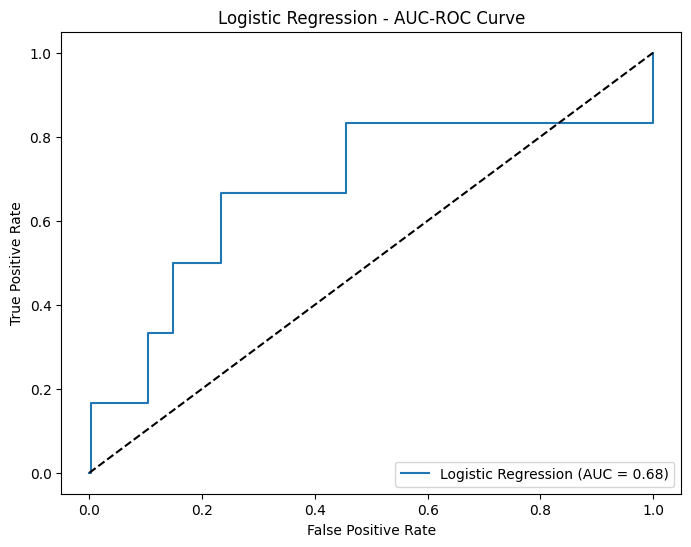

In [39]:
update_items = {
  'loc': 'numerical',
  'nOutgoingExternFlsCalled': 'numerical',
  'nOutgoingExternFlsCalledUniq': 'numerical',
  'nOutgoingExternCallsUniq': 'numerical',
}

sd1, train_df = do_sdv(X_train, y_train, updateDict= update_items )
results_syn_sdv = dict()

# Add synthetic data at different percentages to the main DataFrame
for ratio in ratios:
    combined_df = add_synthetic_data(train_df, sd1, ratio)
    y_train_sdv = combined_df.iloc[:, -1]
    X_train_sdv = combined_df.iloc[:, :-1]

    preprocessed_X_train_sdv, scaler, imputer = preprocess_data_train(X_train_sdv)
    preprocessed_X_test_sdv = preprocess_data_test(X_test, scaler, imputer)

    X_train_sdv, y_train_sdv = preprocessed_X_train_sdv, y_train_sdv.to_numpy()
    X_test_sdv, y_test_sdv = preprocessed_X_test_sdv, y_test.to_numpy()

    print(f"Train data combined with {ratio * 100}% synthetic data of minority class:")
    results = evaluate_models(X_train_sdv, X_test_sdv, y_train_sdv, y_test_sdv)
    results_syn_sdv[ratio] = results
    print(results)
    print("_______________________________________________________________________________")

nonecholoc                      float64
loc                             float64
nmethods                        float64
ccomdeep                        float64
ccom                            float64
nest                            float64
hvol                            float64
nIncomingCalls                  float64
nIncomingCallsUniq              float64
nOutgoingInternCalls            float64
nOutgoingExternFlsCalled        float64
nOutgoingExternFlsCalledUniq    float64
nOutgoingExternCallsUniq        float64
dtype: object

# Calling SMOTE-Oversampling

In [ ]:
results_smote = dict()

for ratio in ratios:

    X_train_smote, y_train_smote = smote_oversampling(X_train.to_numpy(), y_train.to_numpy(), [ratio])
    preprocessed_X_train_smote, scaler, imputer = preprocess_data_train((np.array(X_train_smote))[0])
    preprocessed_X_test_smote = preprocess_data_test(X_test, scaler, imputer)

    X_train_smote, y_train_smote = preprocessed_X_train_smote, (np.array(y_train_smote))[0]
    X_test_smote, y_test_smote = preprocessed_X_test_smote, y_test.to_numpy()

    print(f"Train data combined with {ratio * 100}% synthetic data of minority class:")
    print(len(X_train_smote), len(y_train_smote))
    results = evaluate_models(X_train_smote, X_test_smote, y_train_smote, y_test_smote)
    results_smote[ratio] = results
    print(results)
    print("_______________________________________________________________________________")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Train data combined with 20.0% synthetic data of minority class:
1965 1965
{'Logistic Regression': {'Accuracy': 0.9733009708737864, 'Precision': 0.14285714285714285, 'Recall': 0.16666666666666666, 'F1 Score': 0.15384615384615383, 'ROC AUC': 0.8587848932676518, 'Confusion Matrix': array([[400,   6],
       [  5,   1]])}, 'SVM': {'Accuracy': 0.9781553398058253, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.5443349753694581, 'Confusion Matrix': array([[403,   3],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9660194174757282, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49014778325123154, 'Confusion Matrix': array([[398,   8],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 40.0% synthetic data of minority class:
2287 2287


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9441747572815534, 'Precision': 0.13043478260869565, 'Recall': 0.5, 'F1 Score': 0.20689655172413793, 'ROC AUC': 0.8559113300492611, 'Confusion Matrix': array([[386,  20],
       [  3,   3]])}, 'SVM': {'Accuracy': 0.9635922330097088, 'Precision': 0.09090909090909091, 'Recall': 0.16666666666666666, 'F1 Score': 0.11764705882352942, 'ROC AUC': 0.5779967159277504, 'Confusion Matrix': array([[396,  10],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.9563106796116505, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.4852216748768473, 'Confusion Matrix': array([[394,  12],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 60.00000000000001% synthetic data of minority class:
2608 2608


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


KeyboardInterrupt: 

# Calling Random-Oversampling

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Train data combined with 20.0% synthetic data of minority class:
1965 1965
{'Logistic Regression': {'Accuracy': 0.9805825242718447, 'Precision': 0.25, 'Recall': 0.16666666666666666, 'F1 Score': 0.2, 'ROC AUC': 0.776272577996716, 'Confusion Matrix': array([[403,   3],
       [  5,   1]])}, 'SVM': {'Accuracy': 0.9805825242718447, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.5168308702791461, 'Confusion Matrix': array([[404,   2],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9805825242718447, 'Precision': 0.25, 'Recall': 0.16666666666666666, 'F1 Score': 0.2, 'ROC AUC': 0.5796387520525452, 'Confusion Matrix': array([[403,   3],
       [  5,   1]])}}
_______________________________________________________________________________
Train data combined with 40.0% synthetic data of minority class:
2287 2287


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9441747572815534, 'Precision': 0.09523809523809523, 'Recall': 0.3333333333333333, 'F1 Score': 0.14814814814814814, 'ROC AUC': 0.7783251231527094, 'Confusion Matrix': array([[387,  19],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9684466019417476, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.7130541871921182, 'Confusion Matrix': array([[399,   7],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9757281553398058, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49507389162561577, 'Confusion Matrix': array([[402,   4],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 60.00000000000001% synthetic data of minority class:
2608 2608


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': {'Accuracy': 0.8859223300970874, 'Precision': 0.08163265306122448, 'Recall': 0.6666666666666666, 'F1 Score': 0.14545454545454545, 'ROC AUC': 0.777504105090312, 'Confusion Matrix': array([[361,  45],
       [  2,   4]])}, 'SVM': {'Accuracy': 0.9296116504854369, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.7220853858784894, 'Confusion Matrix': array([[383,  23],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9805825242718447, 'Precision': 0.25, 'Recall': 0.16666666666666666, 'F1 Score': 0.2, 'ROC AUC': 0.5796387520525452, 'Confusion Matrix': array([[403,   3],
       [  5,   1]])}}
_______________________________________________________________________________
Train data combined with 80.0% synthetic data of minority class:
2930 2930


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.8300970873786407, 'Precision': 0.05555555555555555, 'Recall': 0.6666666666666666, 'F1 Score': 0.10256410256410256, 'ROC AUC': 0.7885878489326765, 'Confusion Matrix': array([[338,  68],
       [  2,   4]])}, 'SVM': {'Accuracy': 0.8883495145631068, 'Precision': 0.023809523809523808, 'Recall': 0.16666666666666666, 'F1 Score': 0.041666666666666664, 'ROC AUC': 0.6814449917898194, 'Confusion Matrix': array([[365,  41],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.970873786407767, 'Precision': 0.125, 'Recall': 0.16666666666666666, 'F1 Score': 0.14285714285714288, 'ROC AUC': 0.5747126436781609, 'Confusion Matrix': array([[399,   7],
       [  5,   1]])}}
_______________________________________________________________________________
Train data combined with 100.0% synthetic data of minority class:
3252 3252


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


KeyboardInterrupt: 

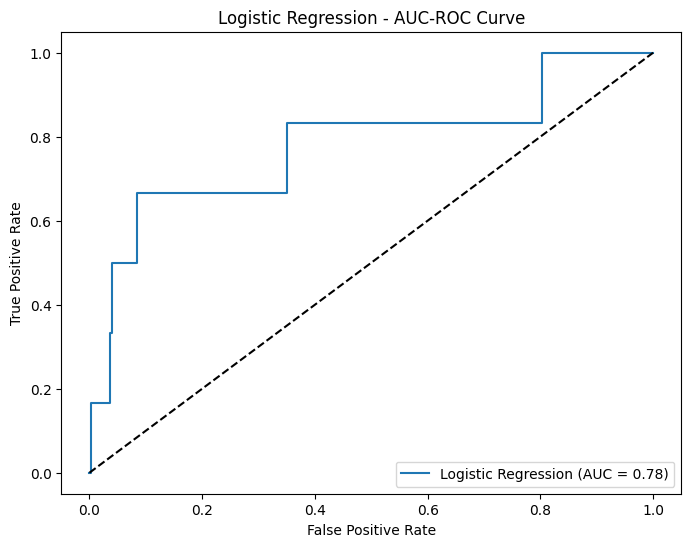

In [ ]:
results_random = dict()

for ratio in ratios:

    X_train_random, y_train_random = random_oversampling(X_train.to_numpy(), y_train.to_numpy(), [ratio])

    preprocessed_X_train_random, scaler, imputer = preprocess_data_train((np.array(X_train_random)[0]))
    preprocessed_X_test_random = preprocess_data_test(X_test, scaler, imputer)

    X_train_random, y_train_random = preprocessed_X_train_random, (np.array(y_train_random))[0]
    X_test_random, y_test_random = preprocessed_X_test_random, y_test.to_numpy()

    print(f"Train data combined with {ratio * 100}% synthetic data of minority class:")
    print(len(X_train_random), len(y_train_random))
    results = evaluate_models(X_train_random, X_test_random, y_train_random, y_test_random)
    results_random[ratio] = results
    print(results)
    print("_______________________________________________________________________________")

# Calling SVM-SMOTE Over-Sampling

In [ ]:
results_svm_smote = dict()

for ratio in ratios:

    X_train_svm_smote, y_train_svm_smote = svm_smote_oversampling(X_train.to_numpy(), y_train.to_numpy(), [ratio])

    preprocessed_X_train_svm_smote, scaler, imputer = preprocess_data_train((np.array(X_train_svm_smote))[0])
    preprocessed_X_test_svm_smote = preprocess_data_test(X_test, scaler, imputer)

    X_train_svm_smote, y_train_svm_smote = preprocessed_X_train_svm_smote, (np.array(y_train_svm_smote))[0]
    X_test_svm_smote, y_test_svm_smote = preprocessed_X_test_svm_smote, y_test.to_numpy()

    print(f"Train data combined with {ratio * 100}% synthetic data of minority class:")
    print(len(X_train_svm_smote), len(y_train_svm_smote))
    results = evaluate_models(X_train_svm_smote, X_test_svm_smote, y_train_svm_smote, y_test_svm_smote)
    results_svm_smote[ratio] = results
    print(results)
    print("_______________________________________________________________________________")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Train data combined with 20.0% synthetic data of minority class:
1821 1821
{'Logistic Regression': {'Accuracy': 0.9854368932038835, 'Precision': 0.5, 'Recall': 0.3333333333333333, 'F1 Score': 0.4, 'ROC AUC': 0.8000821018062397, 'Confusion Matrix': array([[404,   2],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9830097087378641, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.38013136288998356, 'Confusion Matrix': array([[405,   1],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9635922330097088, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.48891625615763545, 'Confusion Matrix': array([[397,   9],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 40.0% synthetic data of minority class:
1998 1998


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9805825242718447, 'Precision': 0.3333333333333333, 'Recall': 0.3333333333333333, 'F1 Score': 0.3333333333333333, 'ROC AUC': 0.7980295566502463, 'Confusion Matrix': array([[402,   4],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9830097087378641, 'Precision': 0.3333333333333333, 'Recall': 0.16666666666666666, 'F1 Score': 0.2222222222222222, 'ROC AUC': 0.367816091954023, 'Confusion Matrix': array([[404,   2],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.9635922330097088, 'Precision': 0.09090909090909091, 'Recall': 0.16666666666666666, 'F1 Score': 0.11764705882352942, 'ROC AUC': 0.5710180623973727, 'Confusion Matrix': array([[396,  10],
       [  5,   1]])}}
_______________________________________________________________________________
Train data combined with 60.00000000000001% synthetic data of minority class:
2174 2174


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9781553398058253, 'Precision': 0.2857142857142857, 'Recall': 0.3333333333333333, 'F1 Score': 0.30769230769230765, 'ROC AUC': 0.8000821018062397, 'Confusion Matrix': array([[401,   5],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9757281553398058, 'Precision': 0.16666666666666666, 'Recall': 0.16666666666666666, 'F1 Score': 0.16666666666666666, 'ROC AUC': 0.36740558292282427, 'Confusion Matrix': array([[401,   5],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.9660194174757282, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49014778325123154, 'Confusion Matrix': array([[398,   8],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 80.0% synthetic data of minority class:
2351 2351


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9781553398058253, 'Precision': 0.2857142857142857, 'Recall': 0.3333333333333333, 'F1 Score': 0.30769230769230765, 'ROC AUC': 0.8025451559934319, 'Confusion Matrix': array([[401,   5],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9757281553398058, 'Precision': 0.16666666666666666, 'Recall': 0.16666666666666666, 'F1 Score': 0.16666666666666666, 'ROC AUC': 0.39367816091954017, 'Confusion Matrix': array([[401,   5],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.9635922330097088, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.48891625615763545, 'Confusion Matrix': array([[397,   9],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 100.0% synthetic data of minority class:
2528 2528


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


{'Logistic Regression': {'Accuracy': 0.9781553398058253, 'Precision': 0.2857142857142857, 'Recall': 0.3333333333333333, 'F1 Score': 0.30769230769230765, 'ROC AUC': 0.8037766830870279, 'Confusion Matrix': array([[401,   5],
       [  4,   2]])}, 'SVM': {'Accuracy': 0.9757281553398058, 'Precision': 0.16666666666666666, 'Recall': 0.16666666666666666, 'F1 Score': 0.16666666666666666, 'ROC AUC': 0.40311986863711, 'Confusion Matrix': array([[401,   5],
       [  5,   1]])}, 'Decision Tree': {'Accuracy': 0.9660194174757282, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49014778325123154, 'Confusion Matrix': array([[398,   8],
       [  6,   0]])}}
_______________________________________________________________________________


# No-Sampling Results

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


Train data combined with 20.0% synthetic data of minority class:
1644 1644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Logistic Regression': {'Accuracy': 0.9830097087378641, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.8206075533661741, 'Confusion Matrix': array([[405,   1],
       [  6,   0]])}, 'SVM': {'Accuracy': 0.9854368932038835, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.4166666666666667, 'Confusion Matrix': array([[406,   0],
       [  6,   0]])}, 'Decision Tree': {'Accuracy': 0.9684466019417476, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC': 0.49137931034482757, 'Confusion Matrix': array([[399,   7],
       [  6,   0]])}}
_______________________________________________________________________________
Train data combined with 40.0% synthetic data of minority class:
1644 1644


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

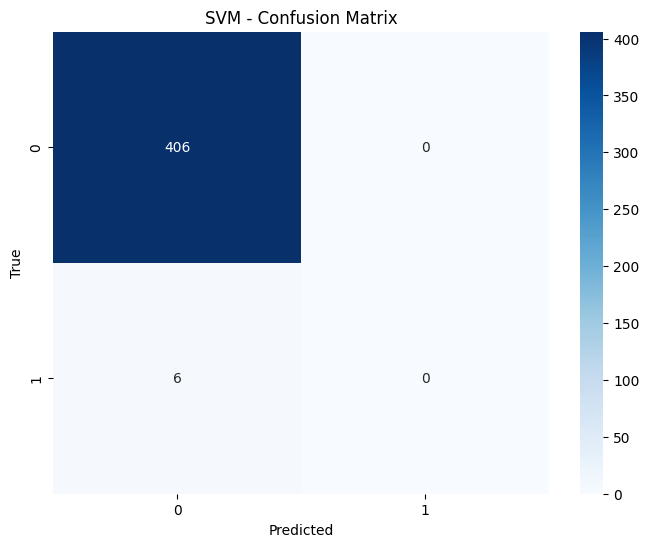

In [ ]:
results_no_sampling = dict()

for ratio in ratios:

    X_train_no_sampling, y_train_no_sampling = X_train.to_numpy(), y_train.to_numpy()

    preprocessed_X_train_no_sampling, scaler, imputer = preprocess_data_train(X_train_no_sampling)
    preprocessed_X_test_no_sampling = preprocess_data_test(X_test, scaler, imputer)

    X_train_no_sampling, y_train_no_sampling = preprocessed_X_train_no_sampling, y_train_no_sampling
    X_test_no_sampling, y_test_no_sampling = preprocessed_X_test_no_sampling, y_test.to_numpy()

    print(f"Train data combined with {ratio * 100}% synthetic data of minority class:")
    print(len(X_train_no_sampling), len(y_train_no_sampling))
    results = evaluate_models(X_train_no_sampling, X_test_no_sampling, y_train_no_sampling, y_test_no_sampling)
    results_no_sampling[ratio] = results
    print(results)
    print("_______________________________________________________________________________")